# Multilayer Perceptron

Previously, [we tried](./02-logistic-regression-word2vec.ipynb) using word embeddings to improve our sentiment classification, but instead of a better score, we got a worse result. That happened because our existing architecture (logistic regression) was unfit for a new vectorization (seemingly much better) approach. But what if we change the architecture itself?

That gives us a nice opportunity to try a different paradigm called **deep learning** - a branch of machine learning and artificial intelligence that uses artificial neural networks to process data and learn patterns. These networks, inspired by the structure of the human brain, are built with multiple layers of interconnected **neurons** that allow them to identify complex relationships and make predictions. 

##  Data Preparation

In [1]:
from datasets import load_dataset
train, test = load_dataset('stanfordnlp/imdb', split=['train', 'test'])
class_names = train.features['label'].names

x_train = train['text']
y_train = train['label']
x_test = test['text']
y_test = test['label']

Our vectorization routine also remains exactly the same. We are doing this to see how the change in *approach* affects the final result without touching any preparational routines.

In [2]:
import numpy as np
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from huggingface_hub import snapshot_download
from os import path

model_path = path.join(snapshot_download('fse/word2vec-google-news-300'), 'word2vec-google-news-300.model')
wv = KeyedVectors.load(model_path)

def vectorize(text):
    tokens = simple_preprocess(text.lower(), deacc=True)
    token_vectors = [wv.get_vector(x) for x in tokens if x in wv]
    if token_vectors:
        return np.mean(token_vectors, axis=0)
    else:
        return np.zeros(wv.vector_size)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

## Data Encoding

Before we proceed further, we need to transform our data. That happens because neural networks do not work with textual information *directly* - instead, we need to encode our data, turning them into some kind of mathematical representation.

In [3]:
x_train = np.array([vectorize(seq) for seq in x_train])
x_test = np.array([vectorize(seq) for seq in x_test])

Labels need to be encoded to. To do this, we may utilise a technique called **one-hot encoding** - it encodes each category as a binary vector where only one element is **hot** (1) and all others are **cold** (0).

In [4]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))
display(y_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Building and Training the Model

Now, let's design our model structure. This time, we will use a thing called **multilayer perceptron**. As its name states, it is a neural network that consists of multiple **layers** of neurons - allowing one to learn complex, non-linear relationships in data (unlike linear regression classifier).

For this task, we will use three types of layers:

- **Input**: Transforms our source data and passes it next.
- **Dense**: Layer of densely connected neurons (each neuron is connected to all other neurons of the neighboring layers).
- **Dropuput**: Special normalization layer that helps against overfitting by randomly disabling parts of the previous layer during the training process.

We may experiment with number of hidden layers and dropout rates - those are, in fact, hyperplanar parameters that may be tuned. Stack more layers meme, you know.

In [5]:
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import layers, Sequential

num_classes = len(class_names)
set_random_seed(0)

model = Sequential([
    layers.Input(shape=(wv.vector_size,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,154 (817.01 KB)

 Trainable params: 209,154 (817.01 KB)

 Non-trainable params: 0 (0.00 B)

None

To aid our training process, we could use an **early stopping** callback. It stops the training process if the validation loss doesn't improve for a set number of epochs, also restoring the best possible weights.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

We can compile and train our model now. Sticking to the CPU may be a good idea for now - using GPU for such a small model may actually slow down the training process due to a huge data transfer overhead.

In [7]:
from tensorflow import device
with device('/CPU'):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=50, batch_size=64, callbacks=[earlystop], validation_split=0.2) 

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7208 - loss: 0.5272 - val_accuracy: 0.6092 - val_loss: 0.8005
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8394 - loss: 0.3675 - val_accuracy: 0.5910 - val_loss: 0.8200
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8457 - loss: 0.3535 - val_accuracy: 0.7012 - val_loss: 0.6369
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8533 - loss: 0.3419 - val_accuracy: 0.7188 - val_loss: 0.6045
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8581 - loss: 0.3360 - val_accuracy: 0.7254 - val_loss: 0.6127
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8545 - loss: 0.3373 - val_accuracy: 0.7362 - val_loss: 0.5887
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8609 - loss: 0.3271 - val_accuracy: 0.7150 - val_loss: 0.6063
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8632 - loss: 0.3212 - val_accuracy: 0.

## Result

In [8]:
from sklearn.metrics import classification_report
with device('/CPU'):
    y_pred_probs = model.predict(x_test, verbose=False)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

         neg       0.85      0.88      0.86     12500
         pos       0.87      0.84      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



Let's take a look at the training history - it may tell us *a lot*.

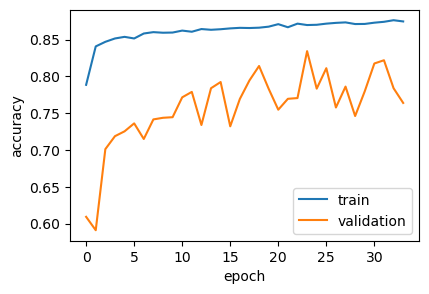

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

We can observe that the training accuracy steadily increases, indicating the model is continuously learning from the training data. However, the validation accuracy shows a different trend - it rises initially but then begins to plateau around epoch 15-20. 

The gap between the training and validation accuracy in later epochs is a classic sign of **overfitting**, where the model becomes too specialized in the training examples, essentially memorizing them. To mitigate this, we might need more training data, or a better model architecture.

## Conclusion

This experiment yielded an **86%** accuracy. While this is the same result as our linear model, it demonstrates a completely different approach to machine learning. The addition of hidden layers and dropout underscores the "stack more layers" principle, at least to a point.

Nevertheless, it still trails our original n-gram model. This suggests that to fully leverage semantic richness, architectures capable of processing sequences are the necessary next step.